# Load libraries and helper functions

In [6]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda, GRU, SimpleRNN, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
#from utils import *
tf.keras.backend.set_floatx('float64')
%load_ext tensorboard

2.4.0


In [7]:
!pip install keras-tuner

In [8]:
import kerastuner as kt

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, horizon=1):
    ds = tf.data.Dataset.from_tensor_slices(series) 
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True) # shifted windows. +1 for target value
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon)) # map into lists of size batch+target
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:])) # split into data and target, x and y
    return ds.batch(batch_size).prefetch(1)

In [10]:
def read_single_file(file):
    value = []

    with open(file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            if (row[7] != 'NA'):
                value.append(row[7])

    series = np.trim_zeros([float(x) if x != 'NA' else 0. for x in value])
    series = pd.DataFrame(series)
    return series

In [11]:
def generate_prediction(model, series, window, horizon, figsize=(10,10)):

    series = np.array(series)
    batches = int(np.floor(len(series) / horizon))
    end = batches * horizon - window
    yhat = []
    for i in range(batches):
        shift = i * horizon
        X = series[0+shift:window+shift]
        X = X[np.newaxis, :]
        y = model.predict(X).flatten()[:horizon]
        yhat.append(y)
    yhat = np.concatenate(yhat, axis=None)[:end]
   
    fig, ax = plt.subplots(figsize=figsize)
    color = next(ax._get_lines.prop_cycler)['color']

    ax.plot(yhat, label = 'prediction', color=color)
    t = [*range(len(yhat))]
    ax.plot(t, yhat, 'o', color=color)
    
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(series[window:], label = 'actual', color=color)
    t = [*range(len(series[window:]))]
    ax.plot(t, series[window:], 'x', color=color)
    plt.legend()
    return yhat

# Load single series

In [12]:
import os
datadir = '.'
files = os.listdir(datadir)
files = [os.path.join(datadir, file) for file in files]

In [13]:
files[1]

'./00_volume.csv'

In [14]:
series = read_single_file(files[1])

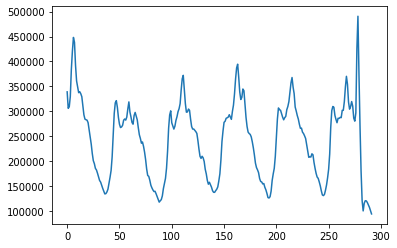

In [15]:
plt.plot(series)

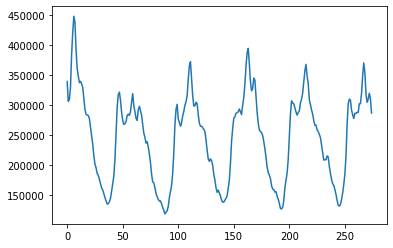

In [16]:
series = series[:275]
plt.plot(series)

## train-test split, normalize

max: 0    448229.135126
dtype: float64


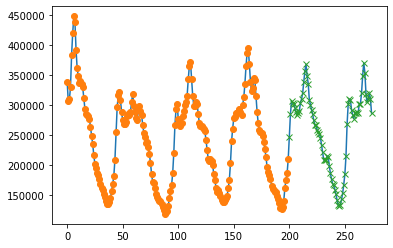

In [17]:
split_time = 200
x_train = series[:split_time]
x_valid = series[split_time:]
plt.plot(series)
plt.plot(x_train, 'o')
plt.plot(x_valid, 'x')

norm = x_train.max()
print('max:', norm)
x_train = x_train / norm
x_valid = x_valid / norm

In [18]:
# shape: (timesteps , features)
x_train.shape, x_valid.shape

((200, 1), (75, 1))

In [ ]:
window_size = 

In [19]:
# make windowed dataset

batch_size = 32
shuffle_buffer_size = 32
horizon = 8 # client wants a horizon of 8

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size, horizon)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size, horizon)